# Всякий потребный функционал для рисовашек

In [1]:
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import itertools

# sklearn
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Матрица ошибок',
                          cmap=plt.cm.Blues,
                          plot_place=[0, 0, 0]):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    plt.subplot(*plot_place)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title + " # " + str(plot_place[2]))
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Истина')
    plt.xlabel('Прогноз')

In [2]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

SPLIT_NUMBER = 4

def confusionMatrices(vectorized_data, estimator, classes = []):
    classes_data = data['class'].apply(lambda x: int(x))
    splits = SPLIT_NUMBER
    kf = KFold(n_splits=splits)
    n = 1
    plt.figure(figsize=(10, 10))
    for train, test in kf.split(vectorized_data):
        estimator.fit(vectorized_data[train], classes_data.iloc[train].values.ravel())
        predicted = estimator.predict(vectorized_data[test])

        matrix = confusion_matrix(classes_data.iloc[test], predicted)
        plot_confusion_matrix(matrix, classes, plot_place=[int(splits / 2) + splits % 2, 2, n])
        n += 1

def crossScores(vectorized_data, estimator):
    classes_data = data['class'].apply(lambda x: int(x))
    crossScoreAccuracy = cross_val_score(estimator, scoring='accuracy', X=vectorized_data, y=classes_data.tolist(), cv=SPLIT_NUMBER)
    crossScoreF = cross_val_score(estimator, scoring='f1', X=vectorized_data, y=classes_data.tolist(), cv=SPLIT_NUMBER)
    crossScoreRocAuc = cross_val_score(estimator, scoring='roc_auc', X=vectorized_data, y=classes_data.tolist(), cv=SPLIT_NUMBER)

    fig, axs = plt.subplots(3, figsize=(8, 15))
    
    print(crossScoreAccuracy)
    axs[0].plot(crossScoreAccuracy)
    axs[0].set_title("Точность")
    axs[0].set(xlabel='Порядковый номер разбиения', ylabel='Значение метрики')

    print(crossScoreF)
    axs[1].plot(crossScoreF)
    axs[1].set_title("F1")
    axs[1].set(xlabel='Порядковый номер разбиения', ylabel='Значение метрики')
    
    print(crossScoreRocAuc)
    axs[2].plot(crossScoreRocAuc)
    axs[2].set_title("ROC AUC")
    axs[2].set(xlabel='Порядковый номер разбиения', ylabel='Значение метрики')


from sklearn.model_selection import GridSearchCV

def gridSearch(vectorized_data, estimator, paramGrid):
    classes_data = data['class'].apply(lambda x: int(x))
    
    xTrain, xTest, yTrain, yTest = train_test_split(vectorized_data, classes_data, test_size=1 / SPLIT_NUMBER)

    searchCV = GridSearchCV(estimator, param_grid=paramGrid, n_jobs=-1, scoring='f1', refit=False)
    searchCV.fit(xTrain, yTrain)
    print(searchCV.best_params_)
    searchCV.cv_results_

# Готовим покушать

In [3]:
import pandas as pd
# from sklearn.utils import shuffle

# suicidal = pd.read_csv("PreparedDatasets/suicidal.csv")
# non_suicidal = pd.read_csv("PreparedDatasets/non_suicidal.csv").head(1000)

# data = suicidal.append(non_suicidal)

# data = shuffle(data)
# data.to_csv("PreparedDatasets/shuffled.csv")
data = pd.read_csv("PreparedDatasets/shuffled.csv")
data

,Unnamed: 0.1,Unnamed: 0,text,class
0,343,423,Ну все ебать!!! Завтра день радости будет!!!,0
1,476,476,Ещё два года назад я потеряла самого близкого ...,1
2,205,248,"Ой, еще люблю, когда ешь что-то, что тебе хоче...",0
3,522,651,в общем в любой непонятной ситуации я кидаю св...,0
4,668,668,Сегодня все закончится. Я так больше не могу. ...,1
...,...,...,...,...
1995,672,672,"В моей стране очень тяжело достать оружие, одн...",1
1996,876,876,"Или я начал сходить с ума , а может что-то или...",1
1997,608,760,"знаете, я передумала. завтра все выучу к 7 уро...",0
1998,118,141,Онет меня забуллили ХАХАХАХАХХАХАХАХАХХАХА,0


# Готовим векторные виды

In [4]:
from pymorphy3 import MorphAnalyzer
import nltk
from nltk.corpus import stopwords

# nltk.download('stopwords')

an = MorphAnalyzer(lang='ru')
stops = stopwords.words('russian')

def getClearSentences(sentences):
    return " ".join(str(s) + "" for s in (an.normal_forms(y)[0] for y in filter(lambda x: x not in stops, nltk.word_tokenize(str(sentences)))))

data['text'] = data['text'].apply(lambda x: getClearSentences(x))
corpus = data['text']

corpus

0                ну ебать ! ! ! завтра день радость ! ! !
1       ещё год назад потерять сам близкий человек , с...
2       ой , любить , есть что-то , ты хотеться . что-...
3       общий любой непонятный ситуация кидать подруга чс
4              сегодня закончиться . я мочь . я уходить .
                              ...                        
1995    в мой страна очень тяжело достать оружие , одн...
1996    или начать сходить ум , что-то кто-то начать п...
1997    знать , передумать . завтра выучить 7 урок пер...
1998                 онет забуллили хахахахаххахахахаххах
1999                                    точка поставить .
Name: text, Length: 2000, dtype: object

In [7]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
vectorized_data_bag = vectorizer.fit_transform(corpus)

import joblib

joblib.dump(vectorizer, "../TermoDemo/vectorizers/bagVectorizer.sav")

['../TermoDemo/vectorizers/bagVectorizer.sav']

In [5]:
from transformers import BertTokenizer, BertModel
from pandas import DataFrame
from scipy.sparse import csr_matrix

tokenizer = BertTokenizer.from_pretrained('cointegrated/rubert-tiny2')

bert_tokenized = corpus.apply(lambda ser: tokenizer.convert_tokens_to_ids(tokenizer.tokenize(ser)))
bert_list = bert_tokenized.tolist()

nRows = len(bert_list)
nCols = max(max(row) if (len(row) > 0) else 0 for row in bert_list) + 1

dataIn = []
indices = []
indptr = [0]

for row in bert_list:
    indices.extend(row)
    dataIn.extend([1] * len(row))
    indptr.append(len(indices))

vectorized_data_bert = csr_matrix((dataIn, indices, indptr), shape=(nRows, nCols))
vectorized_data_bert

<2000x83818 sparse matrix of type '<class 'numpy.int64'>'
	with 88207 stored elements in Compressed Sparse Row format>

# Облака слов и частотность

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords

import dirt_tongue

from string import punctuation

detector = dirt_tongue.is_dirt()
stops = stopwords.words('russian')
dataCloud = data.copy()

dataCloud['text'] = dataCloud['text'].apply(lambda x: nltk.word_tokenize(str(x).lower()))
dataCloud['text'] = dataCloud['text'].apply(lambda z: list(filter(lambda x: x not in punctuation, z)))
dataCloud['text'] = dataCloud['text'].apply(lambda z: list(filter(lambda x: x not in stops, z)))
dataCloud['text'] = dataCloud['text'].apply(lambda z: list(map(lambda x: x if not detector(x) else x[0] + ('*' * (len(x) - 2)) + x[-1], z)))

wordsCloudText = ' '.join(dataCloud[dataCloud['class'] == 1]['text'].apply(lambda x: ' '.join(x)))

print(nltk.FreqDist(wordsCloudText.split()).most_common(10))

cloud = WordCloud(width=1500, height=750, regexp=r"\w[\w*']+").generate(wordsCloudText)
plt.figure(figsize=(20, 10))
plt.imshow(cloud, interpolation='bilinear')
plt.axis('off')
plt.savefig("plots/cloudSuicidal.pdf", format="pdf")

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords

import dirt_tongue

from string import punctuation

detector = dirt_tongue.is_dirt()
stops = stopwords.words('russian')
dataCloud = data.copy()

dataCloud['text'] = dataCloud['text'].apply(lambda x: nltk.word_tokenize(str(x).lower()))
dataCloud['text'] = dataCloud['text'].apply(lambda z: list(filter(lambda x: x not in punctuation, z)))
dataCloud['text'] = dataCloud['text'].apply(lambda z: list(filter(lambda x: x not in stops, z)))
dataCloud['text'] = dataCloud['text'].apply(lambda z: list(map(lambda x: x if not detector(x) else x[0] + ('*' * (len(x) - 2)) + x[-1], z)))

wordsCloudText = ' '.join(dataCloud[dataCloud['class'] == 0]['text'].apply(lambda x: ' '.join(x)))

print(nltk.FreqDist(wordsCloudText.split()).most_common(10))

cloud = WordCloud(width=1500, height=750, regexp=r"\w[\w*']+").generate(wordsCloudText)
plt.figure(figsize=(20, 10))
plt.imshow(cloud, interpolation='bilinear')
plt.axis('off')
plt.savefig("plots/cloudNonSuicidal.pdf", format="pdf")

# Сантименты

In [ ]:
from dostoevsky.tokenization import RegexTokenizer
from dostoevsky.models import FastTextSocialNetworkModel
import matplotlib.pyplot as plt

def sentimentsDiagram(to_analyze):
    tokenizer = RegexTokenizer()
    model = FastTextSocialNetworkModel(tokenizer=tokenizer)

    # Get the sentiment analysis results for the corpus
    results = model.predict(to_analyze, k=2)

    # Define a function to get the sentiment score of a message
    def get_sentiment_score(sentiment_dict):
        if 'positive' in sentiment_dict:
            return sentiment_dict['positive']
        elif 'negative' in sentiment_dict:
            return -sentiment_dict['negative']
        else:
            return 0

    # Calculate the sentiment scores for the corpus
    sentiment_scores = [get_sentiment_score(sentiment) for sentiment in results]

    # Calculate the average sentiment score
    average_sentiment = sum(sentiment_scores) / len(sentiment_scores)

    # Count the number of positive, neutral, and negative sentiments
    positive = sum(1 for score in sentiment_scores if score > 0)
    neutral = sum(1 for score in sentiment_scores if score == 0)
    negative = sum(1 for score in sentiment_scores if score < 0)

    # Create a pie chart to visualize the sentiments
    labels = ['Позитивный', 'Нейтральный', 'Отрицательный']
    sizes = [positive, neutral, negative]
    colors = ['#5cb85c', '#f0ad4e', '#d9534f']
    plt.figure(figsize=(8, 6))
    patches, texts = plt.pie(sizes, colors=colors, startangle=90)
    plt.legend(patches, labels, loc="best")
    plt.axis('equal')
    plt.title('Анализ настроения\nСреднее настроение: {:.2f}'.format(average_sentiment))
    plt.savefig("plots/sentiments_suicidal.pdf", format="pdf")
    plt.show()

In [ ]:
sentimentsDiagram(data[data['class'] == 0]['text'])

In [ ]:
sentimentsDiagram(data[data['class'] == 1]['text'])

# Градиентный бустинг

## Bag

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

estimator = GradientBoostingClassifier()
gridSearch(vectorized_data_bag, estimator, paramGrid={'learning_rate': [0.5], 'min_samples_split': [4, 5], 'n_estimators': [210, 215, 220]})

Confusion matrix, without normalization
[[229  17]
 [ 54 200]]
Confusion matrix, without normalization
[[239  24]
 [ 53 184]]
Confusion matrix, without normalization
[[231  18]
 [ 57 194]]
Confusion matrix, without normalization
[[220  22]
 [ 52 206]]


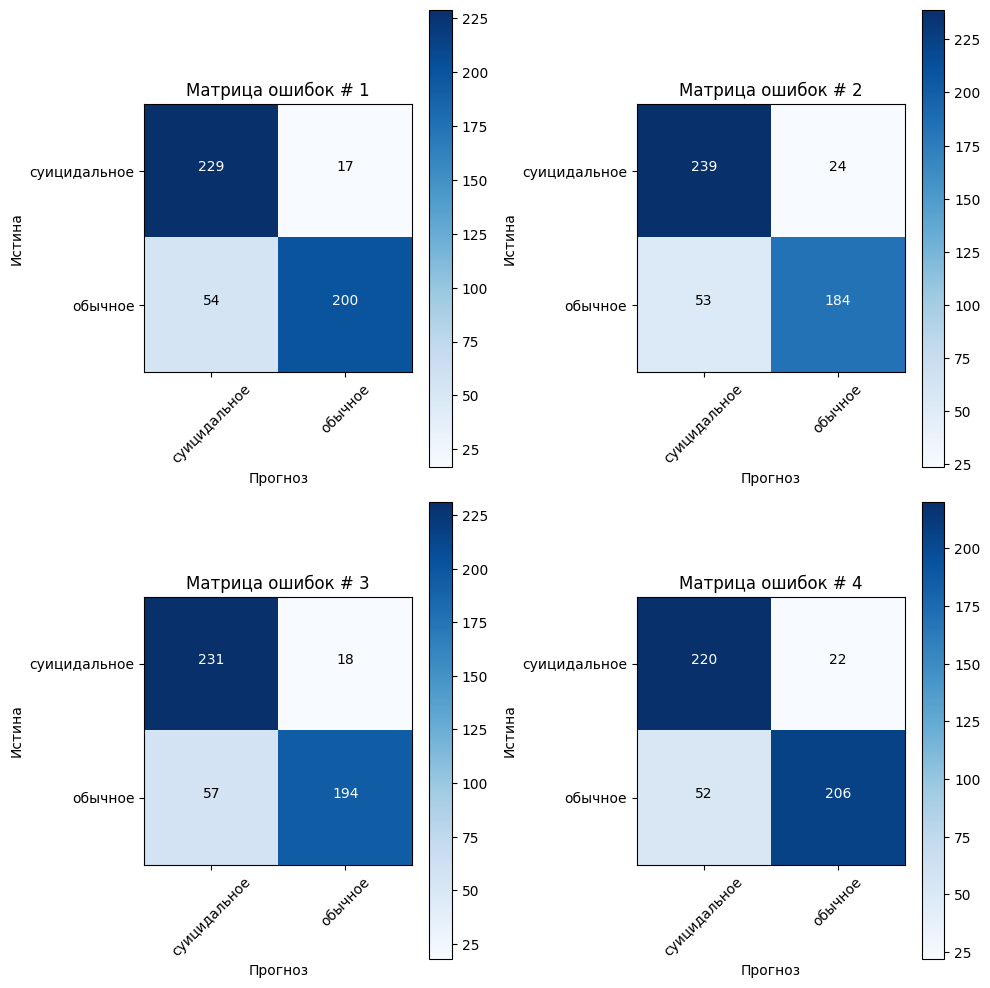

In [8]:
from sklearn.ensemble import GradientBoostingClassifier

estimator = GradientBoostingClassifier(learning_rate=0.5, min_samples_split=5, n_estimators=215)
confusionMatrices(vectorized_data_bag, estimator=estimator, classes=["суицидальное", "обычное"])
plt.savefig("plots/gradientMatrBag.pdf", format="pdf")

[0.858 0.836 0.854 0.864]
[0.84913793 0.82969432 0.84120172 0.85350318]
[0.925832 0.90856  0.901992 0.926304]


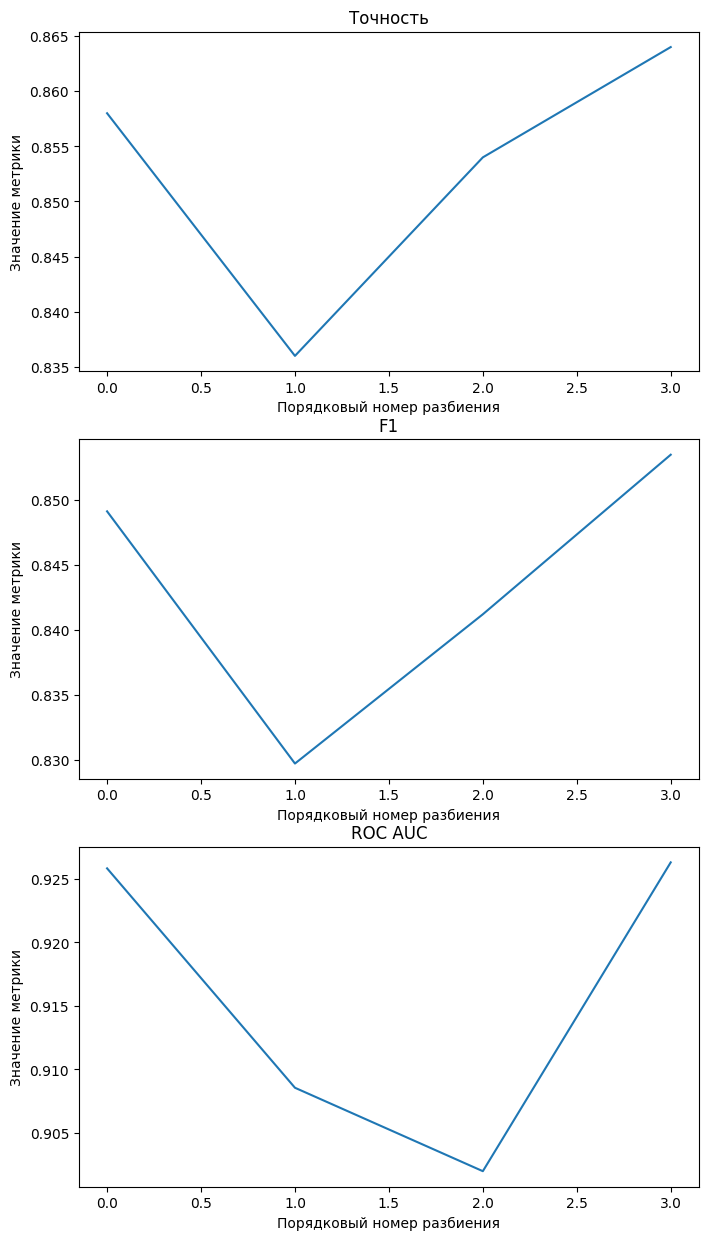

In [9]:
crossScores(vectorized_data_bag, estimator)
plt.savefig("plots/gradientMetricsBag.pdf", format="pdf")

In [19]:
from sklearn.ensemble import GradientBoostingClassifier

estimator = GradientBoostingClassifier(learning_rate=0.5, min_samples_split=5, n_estimators=215)
estimator.fit(vectorized_data_bag, data['class'].apply(lambda x: int(x)))

import joblib
joblib.dump(estimator, "../TermoDemo/models/gradientBag.sav")

['../TermoDemo/models/gradientBag.sav']

## BERT

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

estimator = GradientBoostingClassifier()
gridSearch(vectorized_data_bert, estimator, paramGrid={'learning_rate': [0.3], 'min_samples_split': [16], 'n_estimators': [245]})

Confusion matrix, without normalization
[[223  23]
 [ 50 204]]
Confusion matrix, without normalization
[[235  28]
 [ 50 187]]
Confusion matrix, without normalization
[[232  17]
 [ 52 199]]
Confusion matrix, without normalization
[[225  17]
 [ 45 213]]


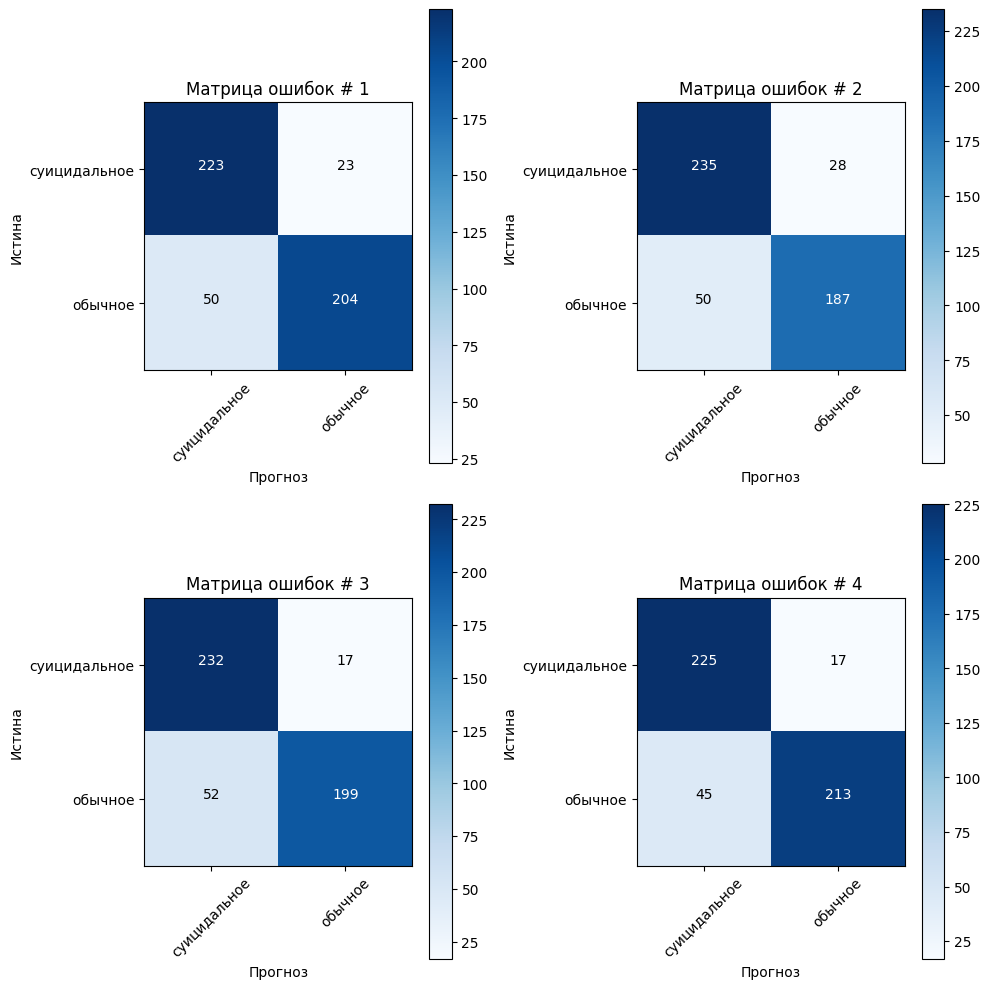

In [10]:
from sklearn.ensemble import GradientBoostingClassifier

estimator = GradientBoostingClassifier(learning_rate=0.3, min_samples_split=16, n_estimators=245)
confusionMatrices(vectorized_data_bert, estimator=estimator, classes=["суицидальное", "обычное"])
plt.savefig("plots/gradientMatrBert.pdf", format="pdf")

[0.868 0.852 0.87  0.89 ]
[0.8487395  0.84008529 0.8516129  0.87631027]
[0.934448 0.917768 0.924008 0.938896]


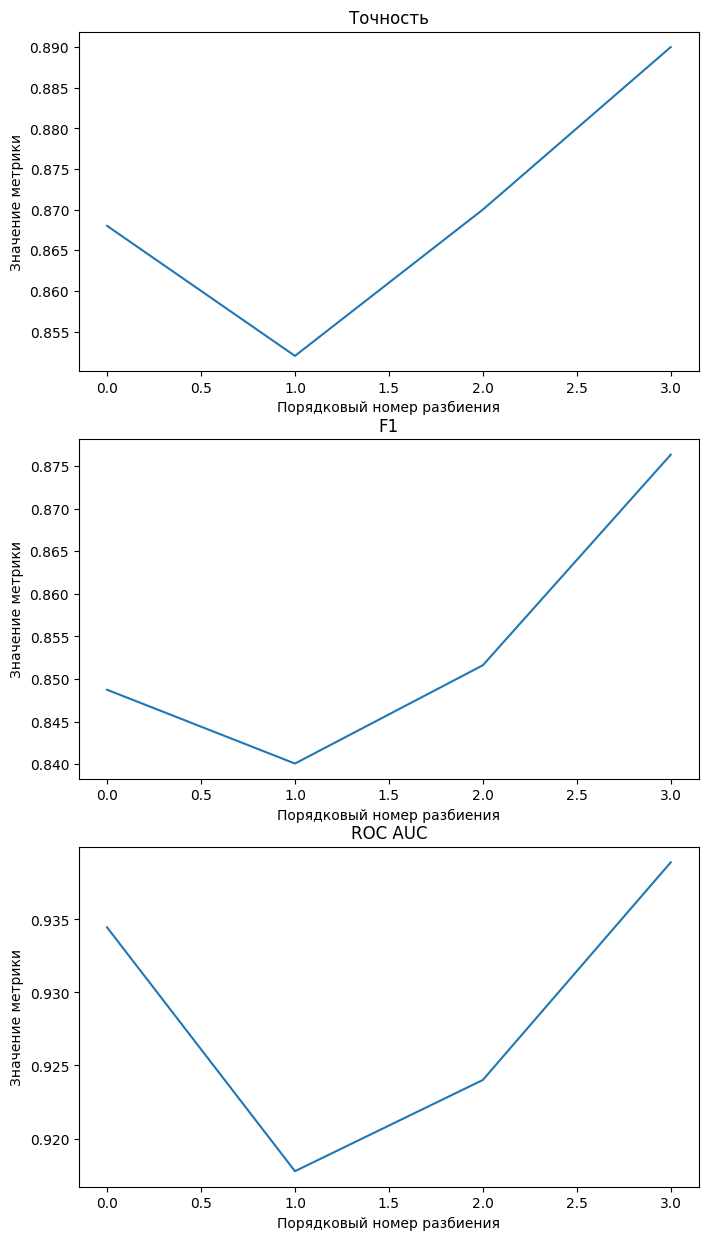

In [11]:
crossScores(vectorized_data_bert, estimator)
plt.savefig("plots/gradientMetricsBert.pdf", format="pdf")

In [20]:
estimator = GradientBoostingClassifier(learning_rate=0.3, min_samples_split=16, n_estimators=245)
estimator.fit(vectorized_data_bert, data['class'].apply(lambda x: int(x)))

import joblib
joblib.dump(estimator, "../TermoDemo/models/gradientBert.sav")

['../TermoDemo/models/gradientBert.sav']

# Random Forest

## Bag

In [ ]:
from sklearn.ensemble import RandomForestClassifier

estimator = RandomForestClassifier()
gridSearch(vectorized_data_bag, estimator, paramGrid={'n_jobs': [-1],'n_estimators': [850, 900, 950], 'max_depth':[300, None], 'max_features': ['sqrt', 'log2', None]})

Confusion matrix, without normalization
[[228  18]
 [ 45 209]]
Confusion matrix, without normalization
[[237  26]
 [ 41 196]]
Confusion matrix, without normalization
[[236  13]
 [ 43 208]]
Confusion matrix, without normalization
[[229  13]
 [ 45 213]]


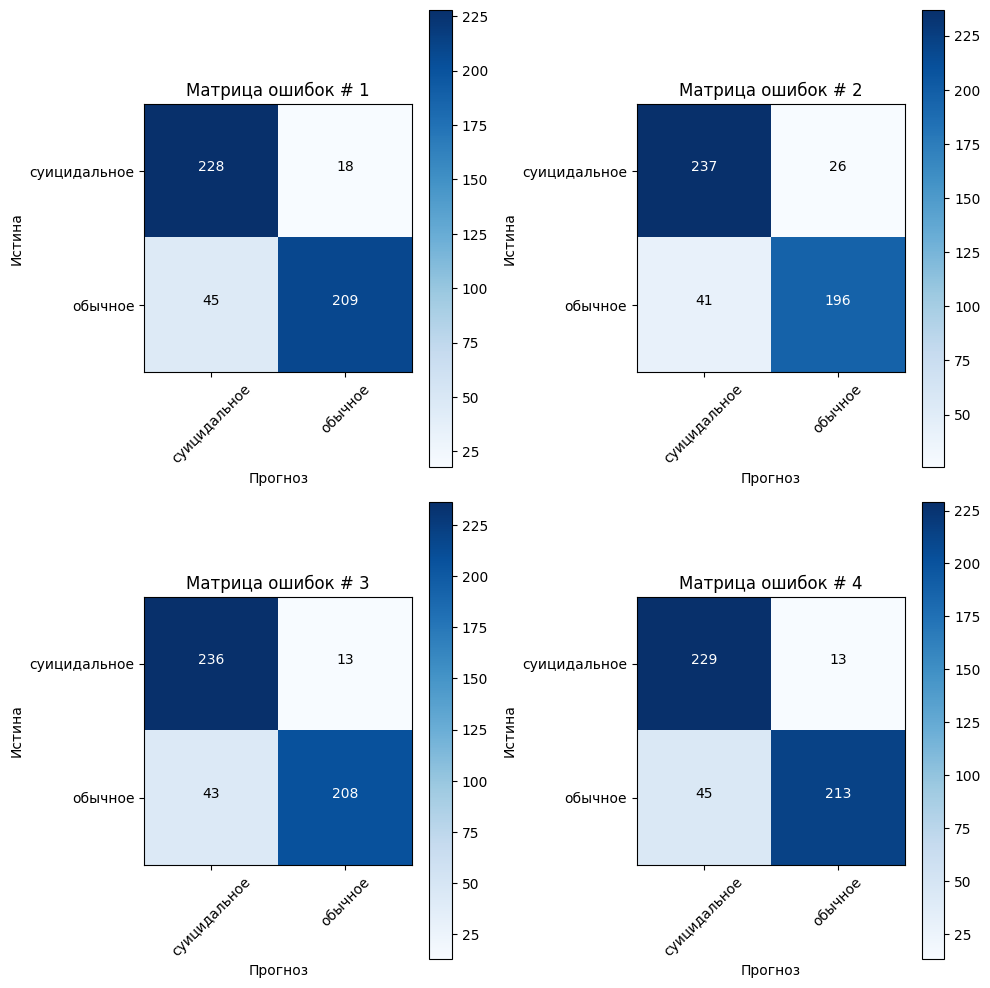

In [12]:
from sklearn.ensemble import RandomForestClassifier

estimator = RandomForestClassifier(max_depth=300, max_features='log2', n_estimators=850, n_jobs=-1)
confusionMatrices(vectorized_data_bag, estimator, ["суицидальное", "обычное"])
plt.savefig("plots/randomMatrBag.pdf", format="pdf")

[0.888 0.876 0.884 0.892]
[0.87578947 0.85774059 0.88085106 0.87659574]
[0.95088  0.941616 0.937416 0.958888]


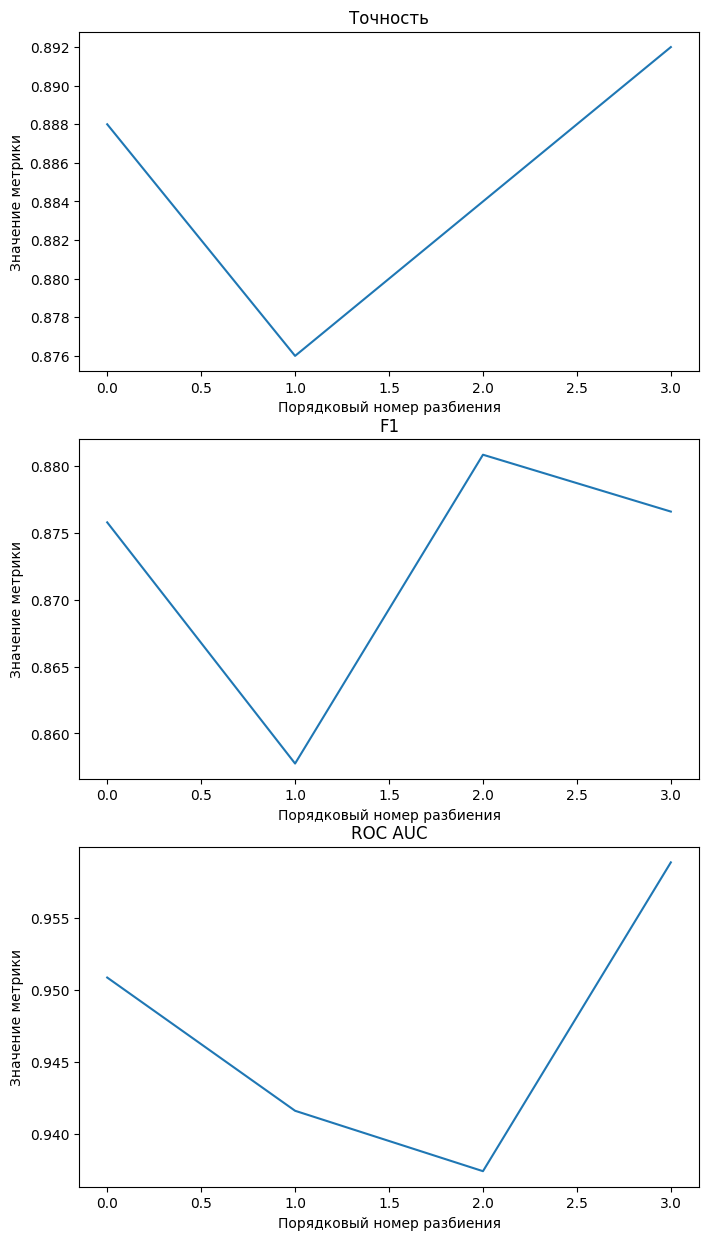

In [13]:
crossScores(vectorized_data_bag, estimator)
plt.savefig("plots/randomMetricsBag.pdf", format="pdf")

In [21]:
from sklearn.ensemble import RandomForestClassifier

estimator = RandomForestClassifier(max_depth=300, max_features='log2', n_estimators=850, n_jobs=-1)
estimator.fit(vectorized_data_bag, data['class'].apply(lambda x: int(x)))

import joblib
joblib.dump(estimator, "../TermoDemo/models/randomBag.sav")

['../TermoDemo/models/randomBag.sav']

## BERT

In [ ]:
from sklearn.ensemble import RandomForestClassifier

estimator = RandomForestClassifier()
gridSearch(vectorized_data_bert, estimator, paramGrid={'n_jobs': [-1],'n_estimators': [2550, 2600, 2650], 'max_depth':[None], 'max_features': ['log2']})

Confusion matrix, without normalization
[[224  22]
 [ 33 221]]
Confusion matrix, without normalization
[[238  25]
 [ 34 203]]
Confusion matrix, without normalization
[[229  20]
 [ 41 210]]
Confusion matrix, without normalization
[[218  24]
 [ 29 229]]


<Figure size 2000x1000 with 0 Axes>

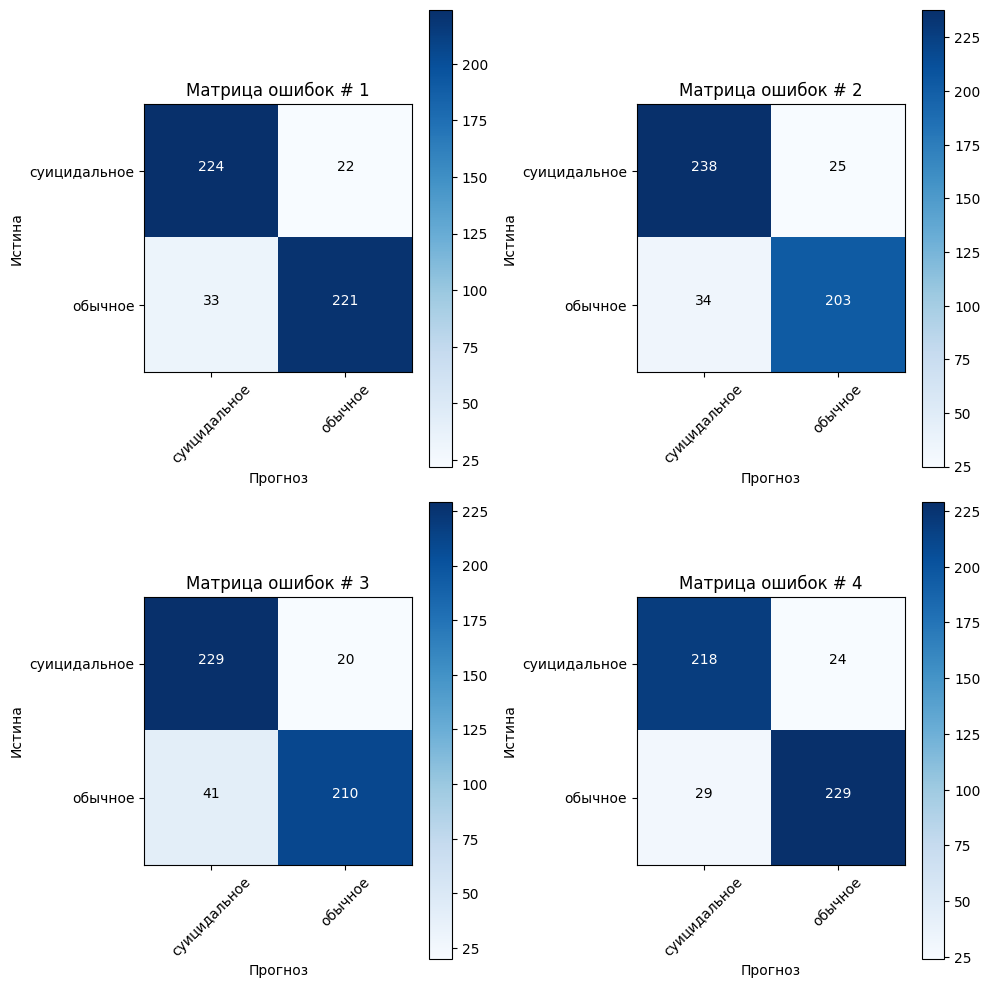

In [14]:
from sklearn.ensemble import RandomForestClassifier

estimator = RandomForestClassifier(max_features='log2', n_estimators=2600, n_jobs=-1)
plt.figure(figsize=(20, 10))
confusionMatrices(vectorized_data_bert, estimator, ["суицидальное", "обычное"])
plt.savefig("plots/randomMatrBert.pdf", format="pdf")

[0.886 0.888 0.878 0.9  ]
[0.88438134 0.88429752 0.8721174  0.90219561]
[0.95352  0.94588  0.935952 0.959824]


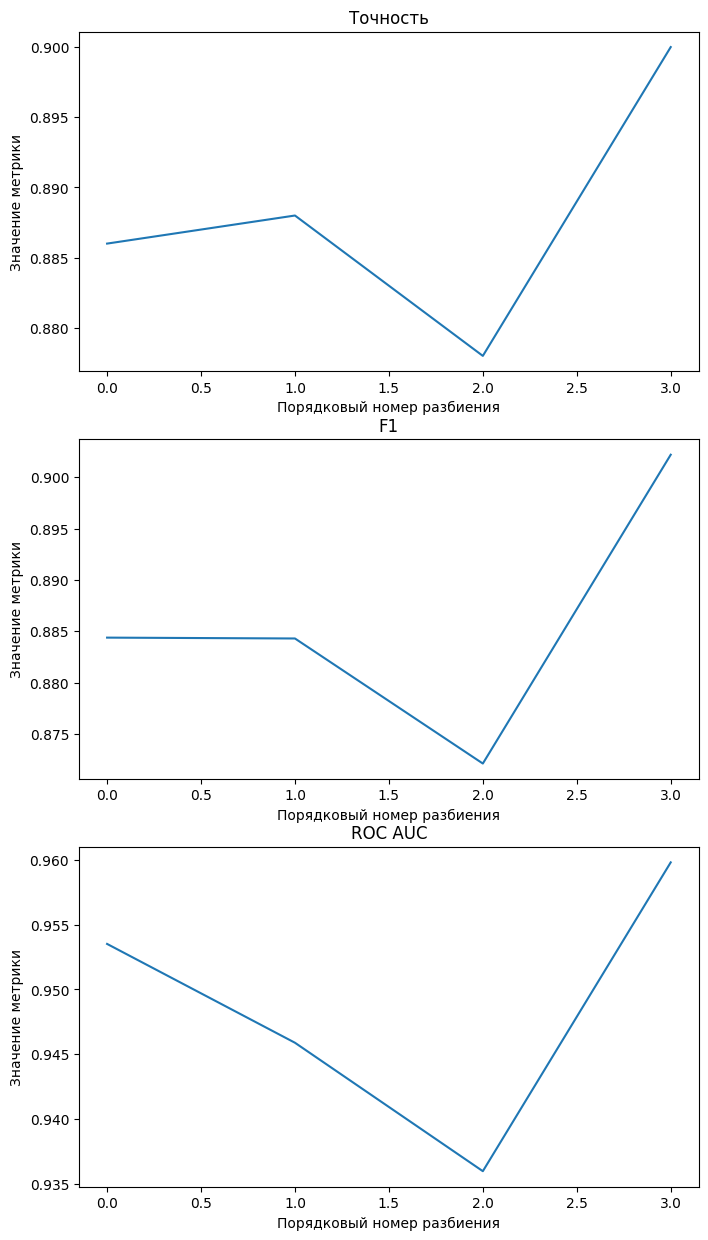

In [15]:
crossScores(vectorized_data_bert, estimator)
plt.savefig("plots/randomMetricsBert.pdf", format="pdf")

In [22]:
from sklearn.ensemble import RandomForestClassifier

estimator = RandomForestClassifier(max_features='log2', n_estimators=2600, n_jobs=-1)
estimator.fit(vectorized_data_bert, data['class'].apply(lambda x: int(x)))

import joblib
joblib.dump(estimator, "../TermoDemo/models/randomBert.sav")

['../TermoDemo/models/randomBert.sav']

In [ ]:
temp_corp = corpus.append(pd.Series([getClearSentences("хочу напиться вусмерть")]))

bert_tokenized = temp_corp.apply(lambda ser: tokenizer.convert_tokens_to_ids(tokenizer.tokenize(ser)))
bert_list = bert_tokenized.tolist()

nRows = len(bert_list)
nCols = max(max(row) if (len(row) > 0) else 0 for row in bert_list) + 1

dataIn = []
indices = []
indptr = [0]

for row in bert_list:
    indices.extend(row)
    dataIn.extend([1] * len(row))
    indptr.append(len(indices))

vectorized_temp = csr_matrix((dataIn, indices, indptr), shape=(nRows, nCols))
estimator.predict(vectorized_temp[-1:])

# SVC

## Bag

In [ ]:
from sklearn.svm import SVC

estimator = SVC()
gridSearch(vectorized_data_bag, estimator, paramGrid={'C': [7.0], 'degree': [2, 3, 4, 6, 7], 'kernel': ['linear', 'poly', 'rbf']})

In [16]:
from sklearn.svm import SVC

estimator = SVC(C=7.0, degree=2, kernel='linear')
confusionMatrices(vectorized_data_bag, estimator, ["суицидальное", "обычное"])
plt.savefig("plots/svcMatrBag.pdf", format="pdf")

NameError: name 'SVC' is not defined

In [ ]:
crossScores(vectorized_data_bag, estimator)
plt.savefig("plots/svcMetricsBag.pdf", format="pdf")

In [23]:
from sklearn.svm import SVC
estimator = SVC(C=7.0, degree=2, kernel='linear')
estimator.fit(vectorized_data_bag, data['class'].apply(lambda x: int(x)))

import joblib
joblib.dump(estimator, "../TermoDemo/models/svcBag.sav")

['../TermoDemo/models/svcBag.sav']

## BERT

In [ ]:
from sklearn.svm import SVC

estimator = SVC()
gridSearch(vectorized_data_bert, estimator, paramGrid={'C': [1.5, 2.0, 2.5], 'degree': [2, 3, 4, 5, 6, 7], 'kernel': ['linear', 'poly', 'rbf']})

In [ ]:
estimator = SVC(C=1.5, degree=2, kernel='linear')
confusionMatrices(vectorized_data_bert, estimator, ["суицидальное", "обычное"])
plt.savefig("plots/svcMatrBert.pdf", format="pdf")

In [ ]:
crossScores(vectorized_data_bert, estimator)
plt.savefig("plots/svcMetricsBert.pdf", format="pdf")

In [24]:
estimator = SVC(C=1.5, degree=2, kernel='linear')
estimator.fit(vectorized_data_bert, data['class'].apply(lambda x: int(x)))

import joblib
joblib.dump(estimator, "../TermoDemo/models/svcBert.sav")

['../TermoDemo/models/svcBert.sav']

# KNN

## Bag

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

estimator = KNeighborsClassifier()
print(gridSearch(vectorized_data_bag, estimator, paramGrid={'n_neighbors': [5, 6, 7], 'weights': ['uniform', 'distance'], 'leaf_size': [4, 5, 6], 'p': [1], 'metric': ['euclidean', 'manhattan']}))

In [ ]:
estimator = KNeighborsClassifier(n_neighbors=5, weights='distance', leaf_size=4, p=1, metric='euclidean')
confusionMatrices(vectorized_data_bag, estimator, ["суицидальное", "обычное"])
plt.savefig("plots/knnMatrBag.pdf", format="pdf")

In [ ]:
crossScores(vectorized_data_bag, estimator)
plt.savefig("plots/knnMetricsBag.pdf", format="pdf")

In [25]:
from sklearn.neighbors import KNeighborsClassifier

estimator = KNeighborsClassifier(n_neighbors=5, weights='distance', leaf_size=4, p=1, metric='euclidean')
estimator.fit(vectorized_data_bag, data['class'].apply(lambda x: int(x)))

import joblib
joblib.dump(estimator, "../TermoDemo/models/knnBag.sav")

['../TermoDemo/models/knnBag.sav']

## BERT

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

estimator = KNeighborsClassifier()
print(gridSearch(vectorized_data_bert, estimator, paramGrid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7], 'weights': ['uniform', 'distance'], 'leaf_size': [1, 2, 3, 4, 5], 'p': [1, 2, 3, 4, 5], 'metric': ['euclidean', 'manhattan']}))

In [ ]:
estimator = KNeighborsClassifier(n_neighbors=6, weights='distance', leaf_size=1, p=1, metric='euclidean')
confusionMatrices(vectorized_data_bert, estimator, ["суицидальное", "обычное"])
plt.savefig("plots/knnMatrBert.pdf", format="pdf")

In [ ]:
crossScores(vectorized_data_bert, estimator)
plt.savefig("plots/knnMetricsBert.pdf", format="pdf")

In [26]:
estimator = KNeighborsClassifier(n_neighbors=6, weights='distance', leaf_size=1, p=1, metric='euclidean')
estimator.fit(vectorized_data_bert, data['class'].apply(lambda x: int(x)))

import joblib
joblib.dump(estimator, "../TermoDemo/models/knnBert.sav")

['../TermoDemo/models/knnBert.sav']

# Logistic Regression

## Bag

In [ ]:
from sklearn.linear_model import LogisticRegression

estimator = LogisticRegression()
gridSearch(vectorized_data_bag, estimator, paramGrid={'penalty': ['l2'], 'C': [2.1, 2.2, 2.3, 2.4], 'class_weight': [{0: 1, 1: 2}, {0: 2, 1: 1}, 'balanced', None], 'solver': ['lbfgs', 'liblinear', 'newton-ct']})

In [ ]:
estimator = LogisticRegression(penalty='l2', C= 2.2, class_weight='balanced', solver='liblinear')
confusionMatrices(vectorized_data_bag, estimator, ["суицидальное", "обычное"])
plt.savefig("plots/logicMatrBag.pdf", format="pdf")

In [ ]:
crossScores(vectorized_data_bag, estimator)
plt.savefig("plots/logicMetricsBag.pdf", format="pdf")

In [27]:
from sklearn.linear_model import LogisticRegression

estimator = LogisticRegression(penalty='l2', C= 2.2, class_weight='balanced', solver='liblinear')
estimator.fit(vectorized_data_bag, data['class'].apply(lambda x: int(x)))

import joblib
joblib.dump(estimator, "../TermoDemo/models/logisticBag.sav")

['../TermoDemo/models/logisticBag.sav']

## BERT

In [ ]:
from sklearn.linear_model import LogisticRegression

estimator = LogisticRegression()
gridSearch(vectorized_data_bert, estimator, paramGrid={'penalty': ['l2'], 'C': [2.1, 2.2, 2.3, 2.4], 'class_weight': [{0: 1, 1: 2}, {0: 2, 1: 1}, 'balanced', None], 'solver': ['liblinear', 'newton-ct']})

In [ ]:
estimator = LogisticRegression(penalty='l2', C= 2.1, class_weight='balanced', solver='liblinear')
confusionMatrices(vectorized_data_bert, estimator, ["суицидальное", "обычное"])
plt.savefig("plots/logicMatrBert.pdf", format="pdf")

In [ ]:
crossScores(vectorized_data_bert, estimator)
plt.savefig("plots/logicMetricsBert.pdf", format="pdf")

In [28]:
estimator = LogisticRegression(penalty='l2', C= 2.1, class_weight='balanced', solver='liblinear')
estimator.fit(vectorized_data_bert, data['class'].apply(lambda x: int(x)))

import joblib
joblib.dump(estimator, "../TermoDemo/models/logisticBert.sav")

['../TermoDemo/models/logisticBert.sav']

# Perceptron

## Bag

In [ ]:
from sklearn.linear_model import Perceptron

estimator = Perceptron()
gridSearch(vectorized_data_bag, estimator, paramGrid={'penalty': ['l2', 'l1', 'elasticnet'], 'alpha': [0.0001, 0.0005, 0.001], 'n_jobs': [-1], 'max_iter': [30], 'class_weight': [{0:1, 1:2}, {0:2, 1:1}, 'balanced', None]})

In [ ]:
estimator = Perceptron(alpha=0.0001, class_weight=None, max_iter=30, penalty='l1', n_jobs=-1)
confusionMatrices(vectorized_data_bag, estimator, ["суицидальное", "обычное"])
plt.savefig("plots/perceptronMatrBag.pdf", format="pdf")

In [ ]:
crossScores(vectorized_data_bag, estimator)
plt.savefig("plots/perceptronMetricsBag.pdf", format="pdf")

In [29]:
from sklearn.linear_model import Perceptron

estimator = Perceptron(alpha=0.0001, class_weight=None, max_iter=30, penalty='l1', n_jobs=-1)
estimator.fit(vectorized_data_bag, data['class'].apply(lambda x: int(x)))

import joblib
joblib.dump(estimator, "../TermoDemo/models/perceptronBag.sav")

['../TermoDemo/models/perceptronBag.sav']

## BERT

In [ ]:
from sklearn.linear_model import Perceptron

estimator = Perceptron()
gridSearch(vectorized_data_bert, estimator, paramGrid={'penalty': ['l2', 'l1', 'elasticnet'], 'alpha': [0.0001, 0.0005, 0.001], 'n_jobs': [-1], 'max_iter': [30, 40, 50, 60, 100, 200, 300, 400], 'class_weight': [{0:1, 1:2}, {0:2, 1:1}, 'balanced', None]})

In [ ]:
estimator = Perceptron(alpha=0.0001, class_weight=None, max_iter=30, penalty='l1', n_jobs=-1)
confusionMatrices(vectorized_data_bert, estimator, ["суицидальное", "обычное"])
plt.savefig("plots/perceptronMatrBert.pdf", format="pdf")

In [ ]:
crossScores(vectorized_data_bert, estimator)
plt.savefig("plots/perceptronMetricsBert.pdf", format="pdf")

In [30]:
estimator = Perceptron(alpha=0.0001, class_weight=None, max_iter=30, penalty='l1', n_jobs=-1)
estimator.fit(vectorized_data_bert, data['class'].apply(lambda x: int(x)))

import joblib
joblib.dump(estimator, "../TermoDemo/models/perceptronBert.sav")

['../TermoDemo/models/perceptronBert.sav']